In [68]:
import json
import re
import wget

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# `with_dataset/`
`with_dataset.zip`を解凍して、フォルダ名を`with_dataset`に変更する。

# `with_dataset/with_user.json`
クロールしたユーザのデータを保存しているjsonファイル

 - `bio`: 自己紹介文
 - `created_at`: ユーザデータを新規作成した日時
 - `updated_at`: ユーザデータを更新した日時
 - `facebook友達数`: facebook上での友達の数
 - `groups`: そのユーザの好み。withでは、「好み」を選ぶことで他のユーザとの共通点を表示する。
 - `image_paths`: ユーザの画像パスをリスト型で保持。これらをダウンロードしたファイルは`with_dataset/imgs/`以下に存在する。
 - `like_count`: 何人からLike(いいかも！)してもらったかを表示

それ以外はカラム名通りのデータ内容を保持している。
ex) `お酒`→よく飲むのか、普通くらいなのか、まったく飲まないのか、etc

In [6]:
WITH_USER_PATH = './with_dataset/with_user.json'

with open(WITH_USER_PATH) as f:
   with_user = json.load(f)

with_user_df = DataFrame(with_user).T
with_user_df.head()

,bio,created_at,facebook友達数,groups,image_paths,like_count,updated_at,お酒,タバコ,ニックネーム,...,性格・タイプ,社交性,結婚に対する意思,結婚歴,職業,職種,血液型,話せる言語,趣味,身長
https://with.is/users/1002682357,時間のある時に埋めていこうと思います。\n\n年齢認証してからじゃないとお返事できないみたい...,2017/10/20 17:00:15,50人以上,"[\n肉好き\n, \n映画が好きです\n, \n居酒屋デートあり‼︎\n, \n綺麗な海が...",[https://cdn.with.is/uploads/user_photo/image/...,509,2017/10/20 17:00:15,NaN,吸わない,H.A.,...,"マイペース, 裏表がない, 面倒見が良い, 仕事好き, 照れ屋, アウトドア, インドア, ...","少人数が好き, すぐに仲良くなる",良い人がいればしたい,未婚‎,NaN,芸能・モデル,A型,日本語,NaN,160cm
https://with.is/users/1025764785,こんにちは。\n\n都内で、マーケティングリサーチの仕事をしてます。\n\n趣味は海外旅行や...,2017/10/20 19:16:56,450人以上,"[\nお酒を飲みながら\n, \n食べるの大好き\n, \n映画が好きです\n, \n自然が...",[https://cdn.with.is/uploads/user_photo/image/...,51,2017/10/20 19:16:56,ときどき飲む,吸わない,やよい,...,"マイペース, 寛容, 負けず嫌い, 聞き上手, 仕事好き, 好奇心旺盛, いつも笑顔, 楽観...","少人数が好き, 一人が好き, すぐに仲良くなる",良い人がいればしたい,未婚‎,リサーチ,WEB業界,A型,日本語,"海外旅行, 読書, ランニング, フジロック",156cm
https://with.is/users/1026758199,仕事を始めてからゴルフの楽しさを発見しました🙌\nお酒と音楽と漫画が好きです。あと旅行！年に...,2017/10/18 10:46:54,200人以上,"[\n居酒屋デートあり‼︎\n, \nパリピは苦手\n, \n一人の時間も大事\n, \nゴ...",[https://cdn.with.is/uploads/user_photo/image/...,5,2017/10/18 10:46:54,飲む,吸わない,ずん,...,"好奇心旺盛, 冷静沈着, 落ち着いている",少人数が好き,2〜3年のうちに,未婚‎,営業,営業・販売,A型,日本語,"音楽(邦ロック), ゴルフ, お酒, 漫画",162cm
https://with.is/users/102682357,こんにちは！はじめまして。\nプロフィールみてくれて、ありがとうございます！\n23歳で、神...,2017/10/18 10:57:38,10人以上,"[\nスポンジボブ\n, \nD.Gray-man\n, \nテニスの王子様が好きな人\n,...",[https://cdn.with.is/uploads/user_photo/image/...,30,2017/10/18 10:57:38,ときどき飲む,吸わない,A.s,...,"さびしがり, いつも笑顔, 照れ屋, インドア, 明るい, 素直","少人数が好き, 一人が好き, すぐに仲良くなる",良い人がいればしたい,未婚‎,NaN,医療関係,O型,日本語,漫画,150cm
https://with.is/users/1027656886,\nはじめまして。\n都内在住の22歳です！\nよく新宿・原宿・池袋ら辺をよくフラフラしてま...,2017/10/19 16:03:44,10人以上,"[\n楽しい事が好き\n, \nコレサワ大好き\n, \n酸欠少女さユり\n, \nポルカド...",[https://cdn.with.is/uploads/user_photo/image/...,338,2017/10/19 16:03:44,ときどき飲む,吸わない,ゆり,...,"気分屋, マイペース, 天然と言われる, 好奇心旺盛, さびしがり, 素直","少人数が好き, 一人が好き, 徐々に仲良くなる",良い人がいればしたい,未婚‎,保育士,保育士,A型,日本語,"漫画, ゲーム, 観劇",164cm


In [10]:
print('ユーザデータ数: %s人分' % with_user_df.shape[0])
print('カラム: %s' % with_user_df.columns.values)

ユーザデータ数: 8414人分
カラム: ['bio' 'created_at' 'facebook友達数' 'groups' 'image_paths' 'like_count'
 'updated_at' 'お酒' 'タバコ' 'ニックネーム' '休日' '体型' '兄弟姉妹' '出会うまでの希望' '出身地'
 '初回デート費用' '同居人' '国籍' '子供の有無' '子供は欲しい' '学歴' '宗教' '家事・育児' '居住地' '年収' '年齢'
 '性格・タイプ' '社交性' '結婚に対する意思' '結婚歴' '職業' '職種' '血液型' '話せる言語' '趣味' '身長']


In [12]:
with_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8414 entries, https://with.is/users/1002682357 to https://with.is/users/9996698875
Data columns (total 36 columns):
bio            8414 non-null object
created_at     8414 non-null object
facebook友達数    8414 non-null object
groups         8414 non-null object
image_paths    8414 non-null object
like_count     8414 non-null object
updated_at     8414 non-null object
お酒             7788 non-null object
タバコ            7090 non-null object
ニックネーム         8410 non-null object
休日             8053 non-null object
体型             7430 non-null object
兄弟姉妹           6658 non-null object
出会うまでの希望       6577 non-null object
出身地            7709 non-null object
初回デート費用        4231 non-null object
同居人            6202 non-null object
国籍             6832 non-null object
子供の有無          6467 non-null object
子供は欲しい         6045 non-null object
学歴             7778 non-null object
宗教             4088 non-null object
家事・育児          4843 non-null object
居住地        

In [13]:
with_user_df.isnull().any()

bio            False
created_at     False
facebook友達数    False
groups         False
image_paths    False
like_count     False
updated_at     False
お酒              True
タバコ             True
ニックネーム          True
休日              True
体型              True
兄弟姉妹            True
出会うまでの希望        True
出身地             True
初回デート費用         True
同居人             True
国籍              True
子供の有無           True
子供は欲しい          True
学歴              True
宗教              True
家事・育児           True
居住地            False
年収              True
年齢             False
性格・タイプ          True
社交性             True
結婚に対する意思        True
結婚歴             True
職業              True
職種              True
血液型             True
話せる言語           True
趣味              True
身長              True
dtype: bool

In [14]:
with_user_df.isnull().all()

bio            False
created_at     False
facebook友達数    False
groups         False
image_paths    False
like_count     False
updated_at     False
お酒             False
タバコ            False
ニックネーム         False
休日             False
体型             False
兄弟姉妹           False
出会うまでの希望       False
出身地            False
初回デート費用        False
同居人            False
国籍             False
子供の有無          False
子供は欲しい         False
学歴             False
宗教             False
家事・育児          False
居住地            False
年収             False
年齢             False
性格・タイプ         False
社交性            False
結婚に対する意思       False
結婚歴            False
職業             False
職種             False
血液型            False
話せる言語          False
趣味             False
身長             False
dtype: bool

In [60]:
with_user_df.index.duplicated().any()

False

(array([  6.31900000e+03,   1.16000000e+03,   4.01000000e+02,
          2.02000000e+02,   1.42000000e+02,   5.70000000e+01,
          5.60000000e+01,   2.50000000e+01,   1.10000000e+01,
          1.30000000e+01,   1.10000000e+01,   5.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

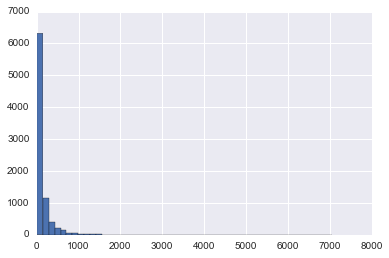

In [25]:
plt.hist(with_user_df.like_count, bins=50)

In [32]:
print('中央値: %s' % with_user_df.like_count.median())
print('平均値: %s' % with_user_df.like_count.mean())
print('最大値: %s' % with_user_df.like_count.max())
print('最小値: %s' % with_user_df.like_count.min())

中央値: 65.0
平均値: 131.702044212
最大値: 7053
最小値: 5


In [37]:
print('中央値より多くいいね！をもらったユーザ数: %s' % with_user_df[with_user_df.like_count > with_user_df.like_count.median()].shape[0])
print('平均値より多くいいね！をもらったユーザ数: %s' % with_user_df[with_user_df.like_count > with_user_df.like_count.mean()].shape[0])

中央値より多くいいね！をもらったユーザ数: 4166
平均値より多くいいね！をもらったユーザ数: 2327


---
# `with_user/imgs/{ユーザID}__{画像ファイル名}.jpg`
各ユーザの画像ファイルのパスは上記のようになっている。例えば、以下の女性ユーザの画像ファイルは以下のコードで表示できる。

In [42]:
# 一番多くいいね！をもらったユーザの画像ファイルを表示
where = (with_user_df.like_count == with_user_df.like_count.max())
target_user_df = with_user_df[where]
target_user_df.head()

,bio,created_at,facebook友達数,groups,image_paths,like_count,updated_at,お酒,タバコ,ニックネーム,...,性格・タイプ,社交性,結婚に対する意思,結婚歴,職業,職種,血液型,話せる言語,趣味,身長
https://with.is/users/4272163785,\n\n食べることと笑うことが幸せです。(*^^*)\n千葉にも東京にも寄っている埼玉県民で...,2017/10/20 16:29:32,150人以上,"[\n居酒屋デートあり‼︎\n, \nフィーリングの合う人がいい\n, \n寝るの大好き\n...",[https://cdn.with.is/uploads/user_photo/image/...,7053,2017/10/20 16:29:32,ときどき飲む,吸わない,みゆ,...,"聞き上手, さびしがり, いつも笑顔, 真面目, 素直",少人数が好き,良い人がいればしたい,未婚‎,NaN,金融,A型,日本語,"テレビ, 旅行, 食べる",155cm


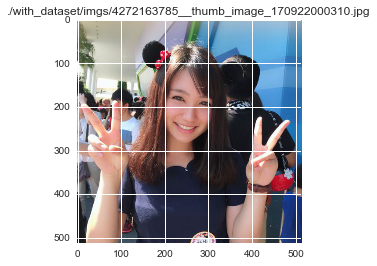

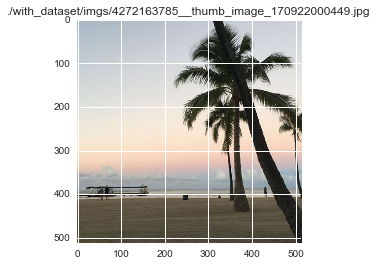

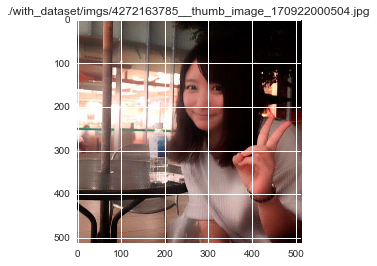

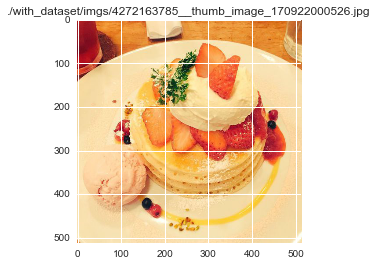

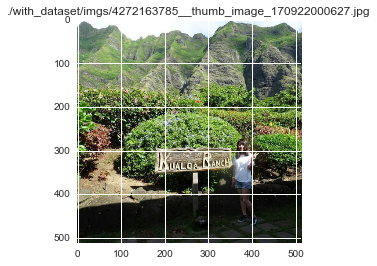

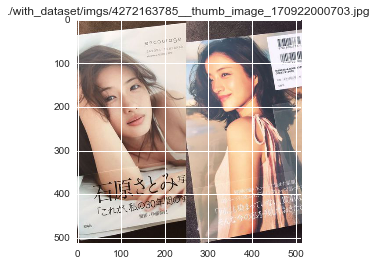

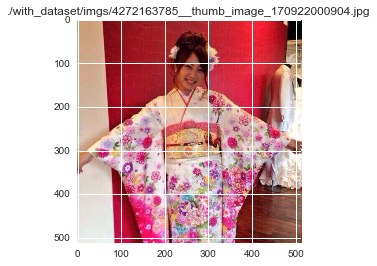

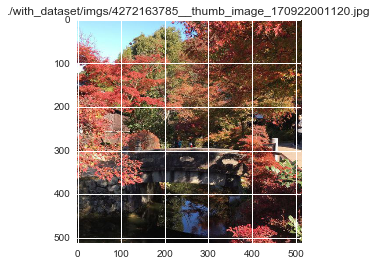

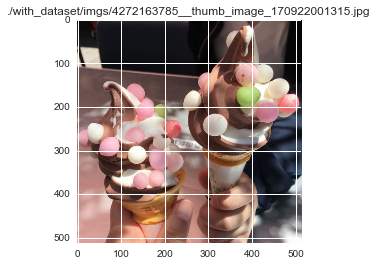

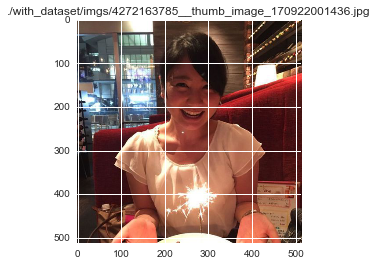

In [73]:
WITH_USER_IMAGE_PATH = './with_dataset/imgs/{user_id}__{file_name}'

for user_url, image_paths in target_user_df['image_paths'].to_dict().items():
    # ユーザIDを取得
    user_id = re.search(r'[0-9]+$', user_url).group()

    for image_path in image_paths:
        # ファイル名を取得
        file_name = wget.filename_from_url(image_path)
        image_file_path = WITH_USER_IMAGE_PATH.format(user_id=user_id, file_name=file_name)

        im = Image.open(image_file_path, 'r')

        plt.title(image_file_path)
        plt.imshow(np.array(im))
        plt.show()